### PINN如何利用神经网络求解PDE
### 先举一个简单的例子，用神经网络模拟微分方程,f(x)'=f(x),初始条件f(0) = 1，没有物理约束
### 这个微分方程其实就是：f(x) = exp(x)

d:\Anaconda3\envs\nn\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


Epoch 0, Loss: 0.6922592520713806


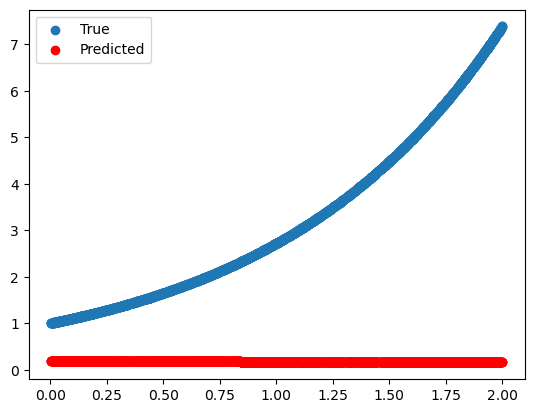

Epoch 1000, Loss: 0.39250850677490234


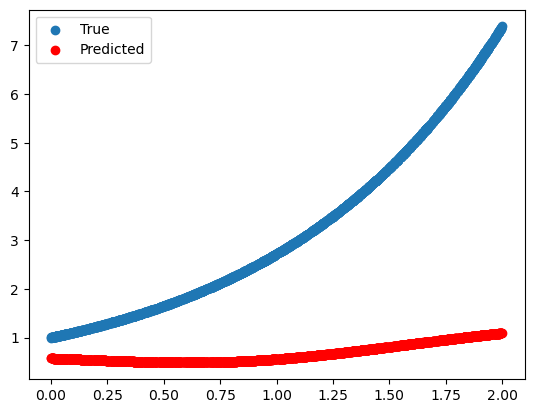

Epoch 2000, Loss: 0.1415686011314392


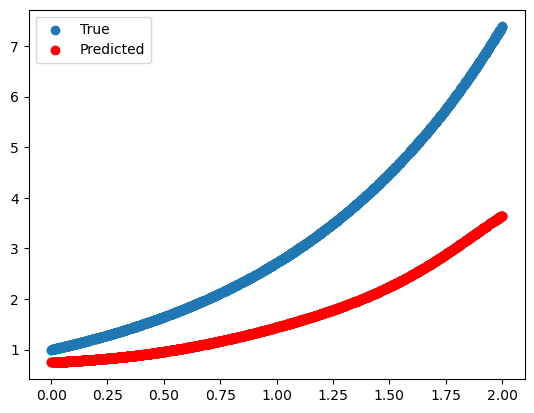

Epoch 3000, Loss: 0.02615773305296898


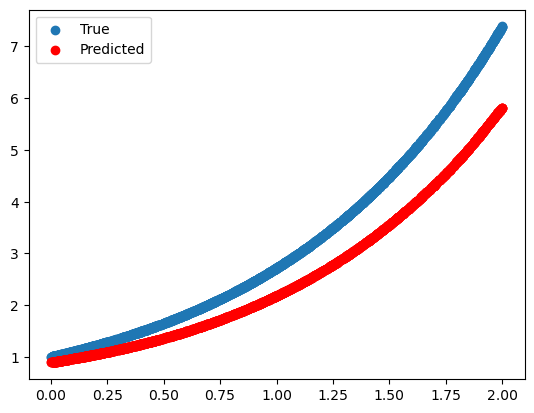

Epoch 4000, Loss: 0.002981708385050297


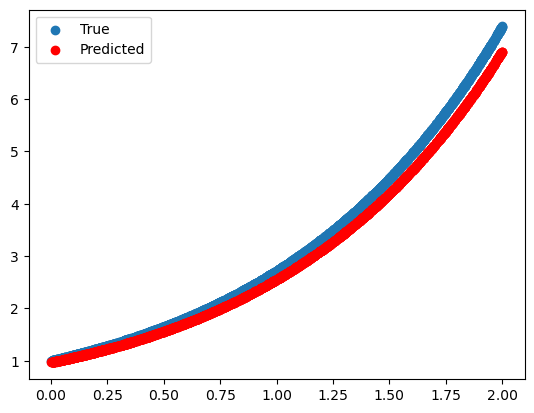

Epoch 5000, Loss: 0.0002398766519036144


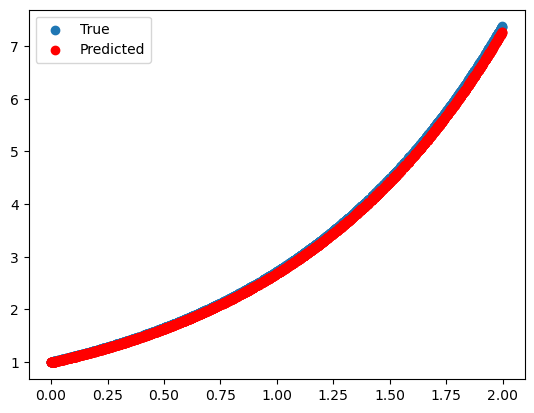

Epoch 6000, Loss: 6.83037651469931e-05


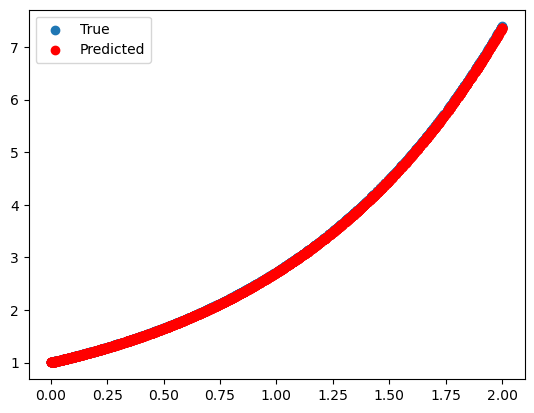

Epoch 7000, Loss: 2.42863388848491e-05


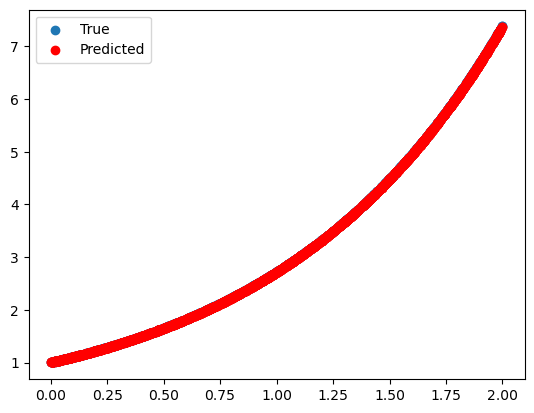

Epoch 8000, Loss: 1.6301624782499857e-05


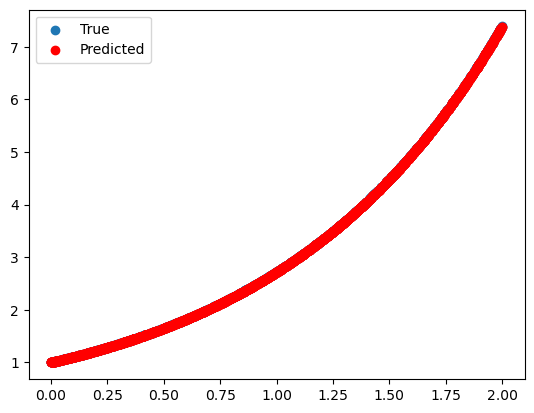

Epoch 9000, Loss: 1.0817841030075215e-05


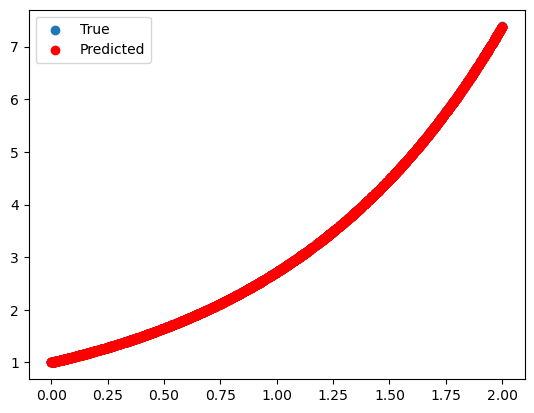

Epoch 10000, Loss: 7.979093425092287e-06


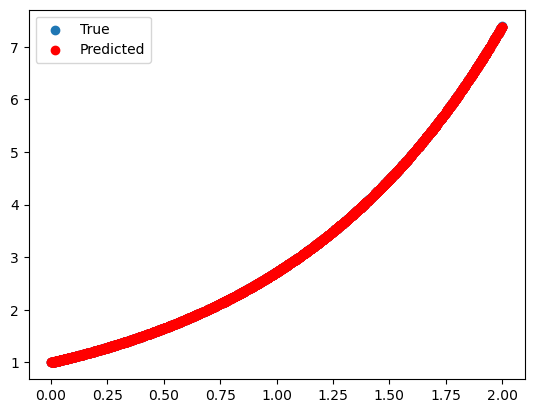

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import autograd

class Net(nn.Module):
    def __init__(self, NL, NN):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, NN))
        for _ in range(NL - 1):
            self.layers.append(nn.Linear(NN, NN))
        self.output_layer = nn.Linear(NN, 1)

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)
        return x

net = Net(4, 20)  # 5层 20个神经元
mse_cost_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

def ode_01(x, net):
    y = net(x)
    y_x = autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return y - y_x  # y - y' = 0

plt.ion()  # 动态图
num_epochs = 10001
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 初始条件损失
    x_0 = torch.zeros(2000, 1, requires_grad=True)
    y_0 = net(x_0)
    mse_i = mse_cost_function(y_0, torch.ones_like(y_0))  # f(0) - 1 = 0

    # 方程损失
    x_in = np.random.uniform(low=0.0, high=2.0, size=(2000, 1))
    pt_x_in = torch.tensor(x_in, dtype=torch.float32, requires_grad=True)
    pt_y_collection = ode_01(pt_x_in, net)
    pt_all_zeros = torch.zeros_like(pt_y_collection)
    mse_f = mse_cost_function(pt_y_collection, pt_all_zeros)  # y - y' = 0

    loss = mse_i + mse_f
    loss.backward()
    optimizer.step() 
    torch.save({
    'model_state_dict': net.state_dict()
        }, 'model.pth')
    if epoch % 1000 == 0:
        with torch.no_grad():
            y_true = torch.exp(pt_x_in)  # y 真实值
            y_pred = net(pt_x_in)  # y 预测值
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            plt.cla()
            plt.scatter(pt_x_in.detach().numpy(), y_true.detach().numpy(), label='True')
            plt.scatter(pt_x_in.detach().numpy(), y_pred.detach().numpy(), c='red', label='Predicted')
            plt.legend()
            plt.pause(0.1)

plt.ioff()
plt.show()


In [6]:
import torch
 
dummy_input = torch.zeros(1, 1)  # 创建一个用于导出的虚拟输入
onnx_filename = "model.onnx"
torch.onnx.export(net, dummy_input, onnx_filename)

print(f"Model saved as {onnx_filename} in ONNX format.")


Model saved as model.onnx in ONNX format.


### 利用PINN解决实际物理问题，以二维瞬态热传导方程为例

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


No backend selected.
Finding available backend...
Found pytorch
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 0.000223 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.37e-02, 9.23e+02, 2.56e+03, 4.08e+02, 4.66e-02, 1.06e-01]    [1.47e-02, 9.23e+02, 2.56e+03, 4.08e+02, 4.66e-02, 1.06e-01]    []  


d:\Anaconda3\envs\nn\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [3.40e+01, 6.66e+00, 1.06e+02, 2.16e+01, 1.10e+00, 1.51e+01]    [2.66e+01, 6.66e+00, 1.06e+02, 2.16e+01, 1.10e+00, 1.51e+01]    []  
2000      [1.16e+01, 1.31e+00, 7.80e+00, 4.31e+00, 1.39e+00, 4.48e+00]    [8.35e+00, 1.31e+00, 7.80e+00, 4.31e+00, 1.39e+00, 4.48e+00]    []  
3000      [8.18e+00, 1.36e+00, 6.15e+00, 1.28e+00, 1.05e+00, 3.33e+00]    [3.81e+00, 1.36e+00, 6.15e+00, 1.28e+00, 1.05e+00, 3.33e+00]    []  
4000      [2.54e+00, 3.83e-01, 2.26e+00, 1.82e-01, 8.15e-01, 9.66e-01]    [2.43e+00, 3.83e-01, 2.26e+00, 1.82e-01, 8.15e-01, 9.66e-01]    []  
5000      [1.08e+01, 5.65e-01, 4.58e+01, 5.87e-01, 1.07e+00, 3.26e+00]    [3.41e+00, 5.65e-01, 4.58e+01, 5.87e-01, 1.07e+00, 3.26e+00]    []  
6000      [1.73e+00, 2.33e-01, 3.71e+00, 1.41e-01, 8.71e-01, 1.37e+00]    [1.42e+00, 2.33e-01, 3.71e+00, 1.41e-01, 8.71e-01, 1.37e+00]    []  
7000      [9.51e-01, 1.32e-01, 1.14e+00, 6.46e-02, 6.91e-01, 4.24e-01]    [2.13e+00, 1.32e-01, 1.14e+00, 6.46e-02, 6.91e-01, 4.24e-01]    []  

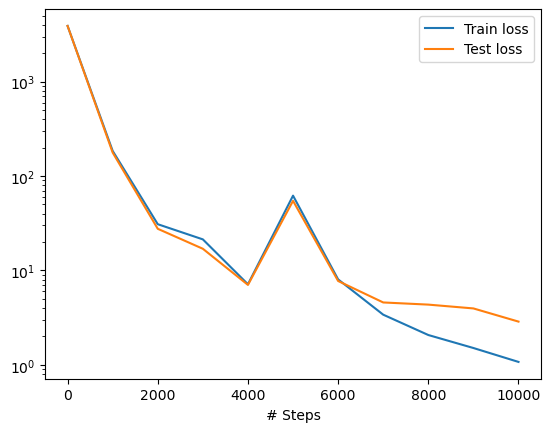

In [8]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import torch

# 指定计算区域
geom = dde.geometry.Rectangle([-1,-1],[1,1])
timedomain = dde.geometry.TimeDomain(0,10)
geomtime = dde.geometry.GeometryXTime(geom,timedomain)

# 定义PDE方程
alpha = 0.5
def pde(x,y):
    dy_t = dde.grad.jacobian(y,x,i=0,j=2)
    dy_xx = dde.grad.hessian(y,x,i=0,j=0)
    dy_yy = dde.grad.hessian(y,x,i=1,j=1)
    return dy_t - alpha * (dy_xx + dy_yy)

# 定义边界
# 上边界，y=1
def boundary_t(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)
# 下边界，y=-1
def boundary_b(x, on_boundary):
    return on_boundary and np.isclose(x[1], -1)
# 左边界，x=-1
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)
# 右边界，x=1
def boundary_r(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

bc_t = dde.icbc.NeumannBC(geomtime, lambda x:0, boundary_t)
bc_b = dde.icbc.NeumannBC(geomtime, lambda x:20, boundary_b)
bc_l = dde.icbc.DirichletBC(geomtime, lambda x:30, boundary_l)
bc_r = dde.icbc.DirichletBC(geomtime, lambda x:50, boundary_r)

# 初值设置为0
def init_func(x):
    return 0

ic = dde.icbc.IC(geomtime,init_func,lambda _,on_initial:on_initial,)

''' 
构造网络
采用6层全连接神经网络:输入层3个神经元,4个隐藏层,每层50个神经元;输出层1个神经元。
激活函数使用tanh,初始化采用Glorot uniform。
'''
data = dde.data.TimePDE(
geomtime,
pde,
[bc_l,bc_r,bc_b,bc_t,ic],
num_domain=8000,
num_boundary=320,
num_initial=800,
num_test=8000,
)

layer_size = [3] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# 训练
losshistory,train_state = model.train(iterations=10000,display_every=1000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### 利用下面代码输出温度随时间变化动画。

In [9]:
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import os

# x,y方向离散200个节点
x1 = np.linspace(-1,1,num=200,endpoint=True).flatten()
y1 = np.linspace(-1,1,num=200,endpoint=True).flatten()
xx1,yy1 = np.meshgrid(x1,y1)
x = xx1.flatten()
y = yy1.flatten()

# 时间上取20个时间步，时间步长1/20=0.05s
Nt = 20
dt = 1/Nt


for n in range(0, Nt+1):
    t = n * dt
    t_list = t*np.ones((len(x), 1))
    x_pred = np.concatenate([x[:, None], y[:, None], t_list], axis=1)
    y_pred = model.predict(x_pred)
    y_p = y_pred.flatten()
    data_n = np.concatenate([x_pred, y_pred], axis=1)
    if n == 0:
        data = data_n[:, :, None]
    else:
        data = np.concatenate([data, data_n[:, :, None]], axis=2)

print(x_pred.shape, y_pred.shape)
print(data.shape, data_n.shape)

# 创建图片保存路径
work_path = os.path.join('2DtransientRectTC',)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)
    print("保存路径: " + work_path)

# 获得y的最大值和最小值
y_min = data.min(axis=(0,2,))[3]
y_max = data.max(axis=(0,2,))[3]
fig = plt.figure(100, figsize=(10, 10))

def anim_update(t_id):
    plt.clf()
    x1_t, x2_t, y_p_t = data[:, 0:1, t_id], data[:, 1:2, t_id], data[:, 3:4, t_id]
    x1_t, x2_t, y_p_t = x1_t.flatten(), x2_t.flatten(), y_p_t.flatten()
    print(t_id, x1_t.shape, x1_t.shape, y_p_t.shape)

    plt.subplot(1,1,1)
    plt.tricontourf(x1_t, x2_t, y_p_t, levels=160, cmap="coolwarm")
    cb0 = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=y_min, vmax=y_max), cmap="coolwarm" ),ax = plt.gca())

    plt.xlabel('$x (m)$')
    plt.ylabel('$y (m)$')
    plt.title("Temperature field at t = " + str(round(t_id * dt,2)) + " s.", fontsize = 12)
    plt.savefig(work_path + '//' + 'animation_' + str(t_id) + '.png')

    print("data.shape[2] = ", data.shape[2])

# 创建gif动画
anim =FuncAnimation(fig, anim_update, frames=np.arange(0, data.shape[2]).astype(np.int64), interval=200)
anim.save(work_path + "//" + "animation-" + str(Nt+1) + ".gif", writer="pillow",dpi=300)

(40000, 3) (40000, 1)
(40000, 4, 21) (40000, 4)
保存路径: 2DtransientRectTC
0 (40000,) (40000,) (40000,)
data.shape[2] =  21
0 (40000,) (40000,) (40000,)
data.shape[2] =  21
1 (40000,) (40000,) (40000,)
data.shape[2] =  21
2 (40000,) (40000,) (40000,)
data.shape[2] =  21
3 (40000,) (40000,) (40000,)
data.shape[2] =  21
4 (40000,) (40000,) (40000,)
data.shape[2] =  21
5 (40000,) (40000,) (40000,)
data.shape[2] =  21
6 (40000,) (40000,) (40000,)
data.shape[2] =  21
7 (40000,) (40000,) (40000,)
data.shape[2] =  21
8 (40000,) (40000,) (40000,)
data.shape[2] =  21
9 (40000,) (40000,) (40000,)
data.shape[2] =  21
10 (40000,) (40000,) (40000,)
data.shape[2] =  21
11 (40000,) (40000,) (40000,)
data.shape[2] =  21
12 (40000,) (40000,) (40000,)
data.shape[2] =  21
13 (40000,) (40000,) (40000,)
data.shape[2] =  21
14 (40000,) (40000,) (40000,)
data.shape[2] =  21
15 (40000,) (40000,) (40000,)
data.shape[2] =  21
16 (40000,) (40000,) (40000,)
data.shape[2] =  21
17 (40000,) (40000,) (40000,)
data.shap